### Importing dependencies

In [1]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [4]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the MobileNet Model Architecture

In [5]:
class MobileNetV1(nn.Module):
    def __init__(self):
        super(MobileNetV1, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                )

        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, 4)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x


## Perform a sanity check for the correctness of the model

In [6]:
net = MobileNetV1()
net = net.to(device)
data = torch.randn(5,3,64,64)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bia

### Move data and the model to the GPU

In [7]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Sun Apr 21 20:34:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              27W /  70W |    181MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [8]:
# hyperparameters
INITIAL_LR = 0.1 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [9]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'MobileNet.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.5957, Training accuracy: 0.4895


validating...: 0it [00:00, ?it/s]

Validation loss: 110.3581, Validation accuracy: 0.4282
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 0.9523, Training accuracy: 0.6279


validating...: 0it [00:00, ?it/s]

Validation loss: 6.3627, Validation accuracy: 0.5347
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 0.5908, Training accuracy: 0.7844


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7209, Validation accuracy: 0.7189
Saving ...

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.4685, Training accuracy: 0.8037


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5203, Validation accuracy: 0.7883
Saving ...

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.4329, Training accuracy: 0.8214


validating...: 0it [00:00, ?it/s]

Validation loss: 0.7254, Validation accuracy: 0.7368

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.5898, Training accuracy: 0.8109


validating...: 0it [00:00, ?it/s]

Validation loss: 2.3851, Validation accuracy: 0.7883

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.4089, Training accuracy: 0.8224


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4096, Validation accuracy: 0.8146
Saving ...

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.3831, Training accuracy: 0.8272


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4889, Validation accuracy: 0.8110

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.3707, Training accuracy: 0.8337


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4512, Validation accuracy: 0.8062

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.3274, Training accuracy: 0.8551


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4720, Validation accuracy: 0.8050

Current learning rate has decayed to 0.100000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.2847, Training accuracy: 0.8820


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3688, Validation accuracy: 0.8529
Saving ...

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.2729, Training accuracy: 0.8857


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2966, Validation accuracy: 0.8756
Saving ...

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.2470, Training accuracy: 0.8973


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4524, Validation accuracy: 0.8457

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.2385, Training accuracy: 0.9095


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3331, Validation accuracy: 0.8589

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.2204, Training accuracy: 0.9143


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3496, Validation accuracy: 0.8565

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.2245, Training accuracy: 0.9136


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4257, Validation accuracy: 0.8517

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.2184, Training accuracy: 0.9167


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4625, Validation accuracy: 0.8254

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.2282, Training accuracy: 0.9167


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3031, Validation accuracy: 0.8732

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.2127, Training accuracy: 0.9184


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3339, Validation accuracy: 0.8732

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.2164, Training accuracy: 0.9156


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3293, Validation accuracy: 0.8696

Current learning rate has decayed to 0.100000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.2079, Training accuracy: 0.9170


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4455, Validation accuracy: 0.8349

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.2061, Training accuracy: 0.9241


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4971, Validation accuracy: 0.8278

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.1814, Training accuracy: 0.9299


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4485, Validation accuracy: 0.8397

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.2078, Training accuracy: 0.9201


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4313, Validation accuracy: 0.8445

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2145, Training accuracy: 0.9184


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2548, Validation accuracy: 0.8983
Saving ...

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.1588, Training accuracy: 0.9391


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4667, Validation accuracy: 0.8266

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.1754, Training accuracy: 0.9347


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2867, Validation accuracy: 0.9019
Saving ...

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.1560, Training accuracy: 0.9473


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5012, Validation accuracy: 0.8206

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.1708, Training accuracy: 0.9408


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4341, Validation accuracy: 0.8301

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.1647, Training accuracy: 0.9425


validating...: 0it [00:00, ?it/s]

Validation loss: 0.2582, Validation accuracy: 0.8959

Optimization finished: best validation accuracy is 0.9019


### Show the plots of the training and validation losses

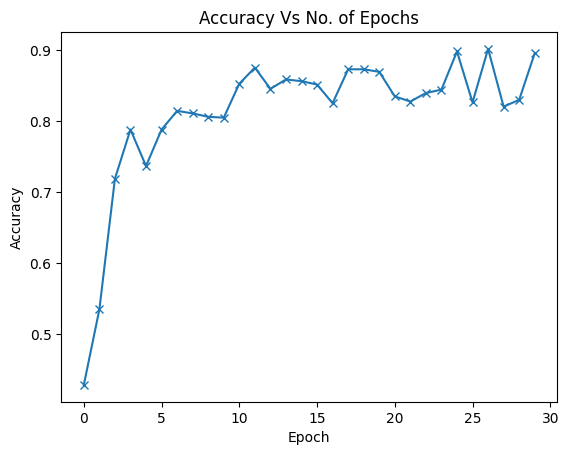

In [10]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

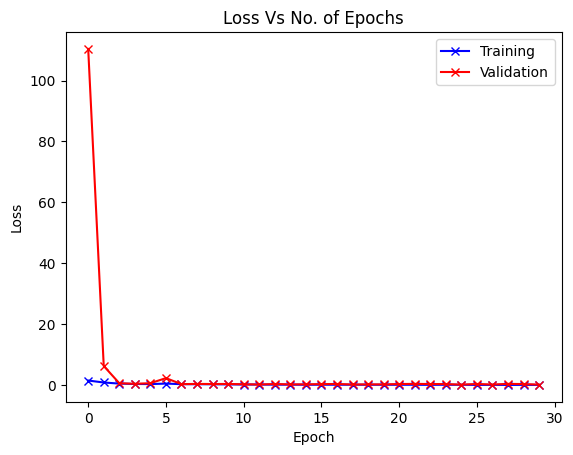

In [11]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

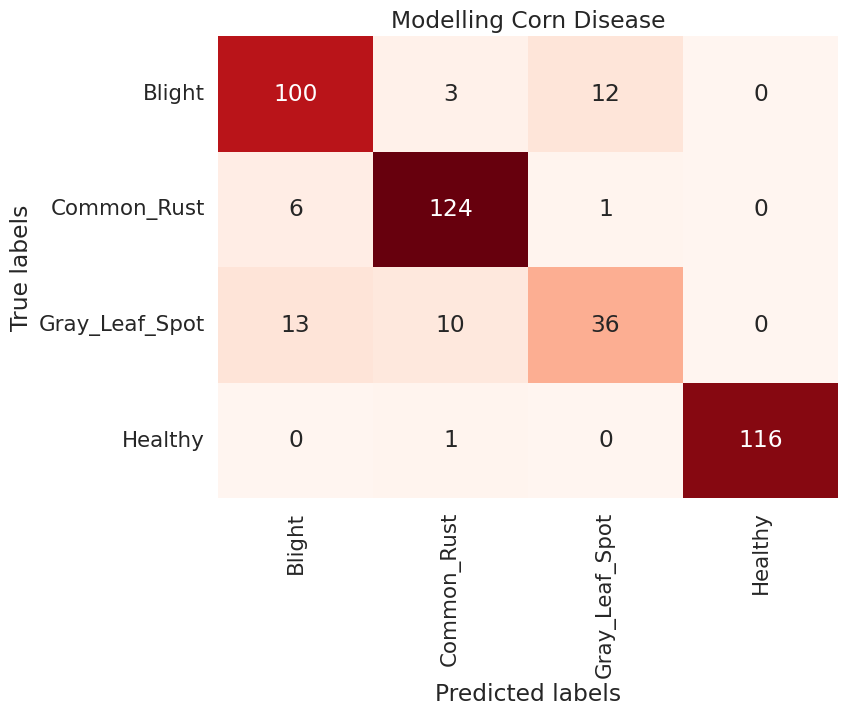

In [12]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

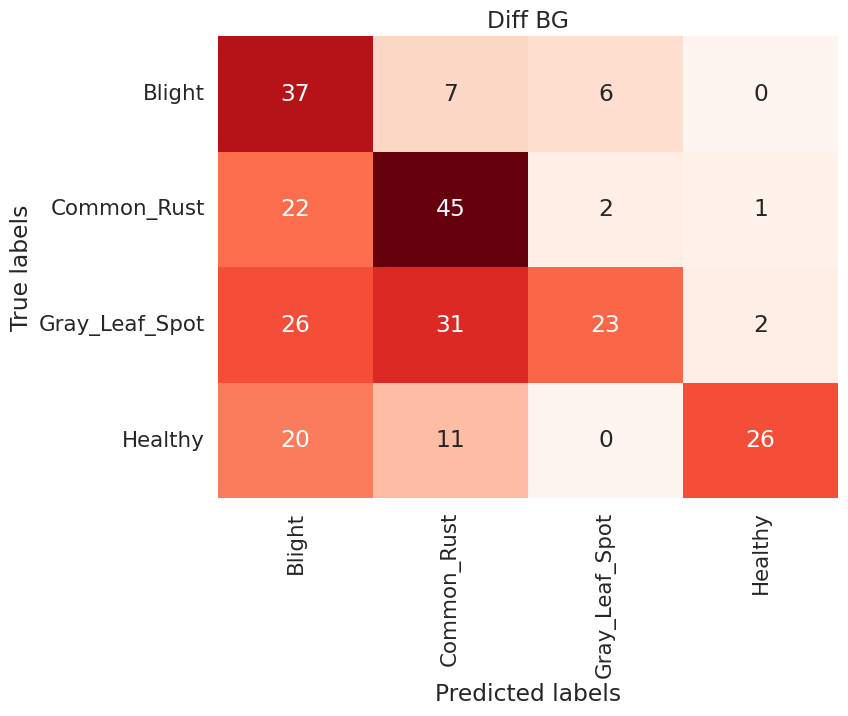

In [13]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()